# Predicting Newsletter Subscription from Player Age and Playtime in Minecraft

## Introduction:
A research group in the Department of Computer Science at the University of British Columbia (UBC), led by Professor Frank Wood, is conducting a study on human behavior in virtual environments. As part of this project, the group has deployed a Minecraft server that records detailed data on player interactions as they navigate the game world. The resulting dataset provides a valuable opportunity to examine behavioral patterns and engagement indicators among players.

This study aims to determine whether player age and total hours played can serve as predictors of newsletter subscription status. Understanding which player characteristics are associated with subscription behavior can inform strategies for community engagement and targeted communication.
## Question:


The analysis is based on the `players.csv` dataset, which includes the following variables:

- experience (character): Player’s experience level (Beginner, Amateur, Regular, Veteran, Pro)

- subscribe (logical): `TRUE` if the player is subscribed to the game newsletter; `FALSE` otherwise

- hashedEmail (character): Unique identifier for each player

- played_hours (double): Total number of hours played by the player

- name (character): Player’s name

- gender (character): Player’s gender

- Age (double): Player’s age

| Dataset   | Number of Rows | Number of Variables | 
|---------------|---------|------------|
 |`players.csv`| 196  |   7      |    
 |`sessions.csv`       |  1535 |     5        |   

### Issues: 
- Missing Values: Some values are missing in the "Age" variable.
- Only players who joined the Minecraft server are included in the dataset. There may be missing players who signed in but never played long enough to produce data.
- Played hours has 0.0 values, which may mean that no hours were played or that the time wasn't logged.

###  Summary Statistics

| Variable   | Mean Value | Maximum Value | Minimum Value |
|---------------|---------|------------|--------------|
 |Played Hours| 5.845918   |   223.1       |      0        |
 |Age         |20.52062    |     50        |      8        |


We started by loading the necessary packages. Then we read in the players.csv file, which contains information about each player, such as their age, hours played, and whether they subscribed to the newsletter. 

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(ggplot2)

options(repr.plot.width = 12, repr.plot.height = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read.csv("https://raw.githubusercontent.com/EL2406/DSCI100/refs/heads/master/players.csv")
set.seed(25)

### Clean and select variables ###
To address our question, we focused on three key variables: Age, played_hours, and subscribe.
We selected only these columns and removed any rows with missing values to avoid issues during modeling. Since subscribe was originally a logical variable (TRUE or FALSE), we converted it into a factor using the as.factor() function. We then checked the levels of this factor to help us decide the appropriate event_level to use in our evaluation step.

In [3]:
players_clean <- players |>
  select(Age, played_hours, subscribe) |>
  drop_na() |>
  mutate(subscribe = as.factor(subscribe))
levels(players_clean$subscribe)

[1] "FALSE" "TRUE"

### Split the data into training and testing sets
To evaluate how well our model performs on new data, we split the dataset into a training set and a testing set. We used 75 percent of the data for training and 25 percent for testing.

In [4]:
player_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

### Create cross validation folds
Before training the model, we applied 5-fold cross-validation to the training data. The purpose of this step was to get a more reliable estimate of model performance and avoid overfitting.

In [5]:
player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

### Set up a data preprocessing recipe
In this step, we created a preprocessing plan for the model. Since KNN is a distance-based algorithm, it is important that all numeric variables are on the same scale. We standardized the two predictor variables, Age and played_hours, by centering and scaling them.

In [6]:
player_recipe <- recipe(subscribe ~ Age + played_hours, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

### Define a KNN model with a tunable k
Next, we defined the structure of our KNN model and allowed the number of neighbors k to be tuned later. 

In [7]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

### Combine our recipe and model into a workflow 
We created a workflow that combined the preprocessing recipe and the KNN model. Then, we tested a range of k values from 1 to 50 using cross-validation. We recorded the average accuracy for each k to help identify which value gave the best performance.

In [8]:
k_grid <- tibble(neighbors = seq(1, 50))

knn_results <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = player_vfold, grid = k_grid)

### Visualize the relationship between k and accuracy
To better understand the effect of different k values, we plotted a graph showing the cross-validated accuracy for each value of k.

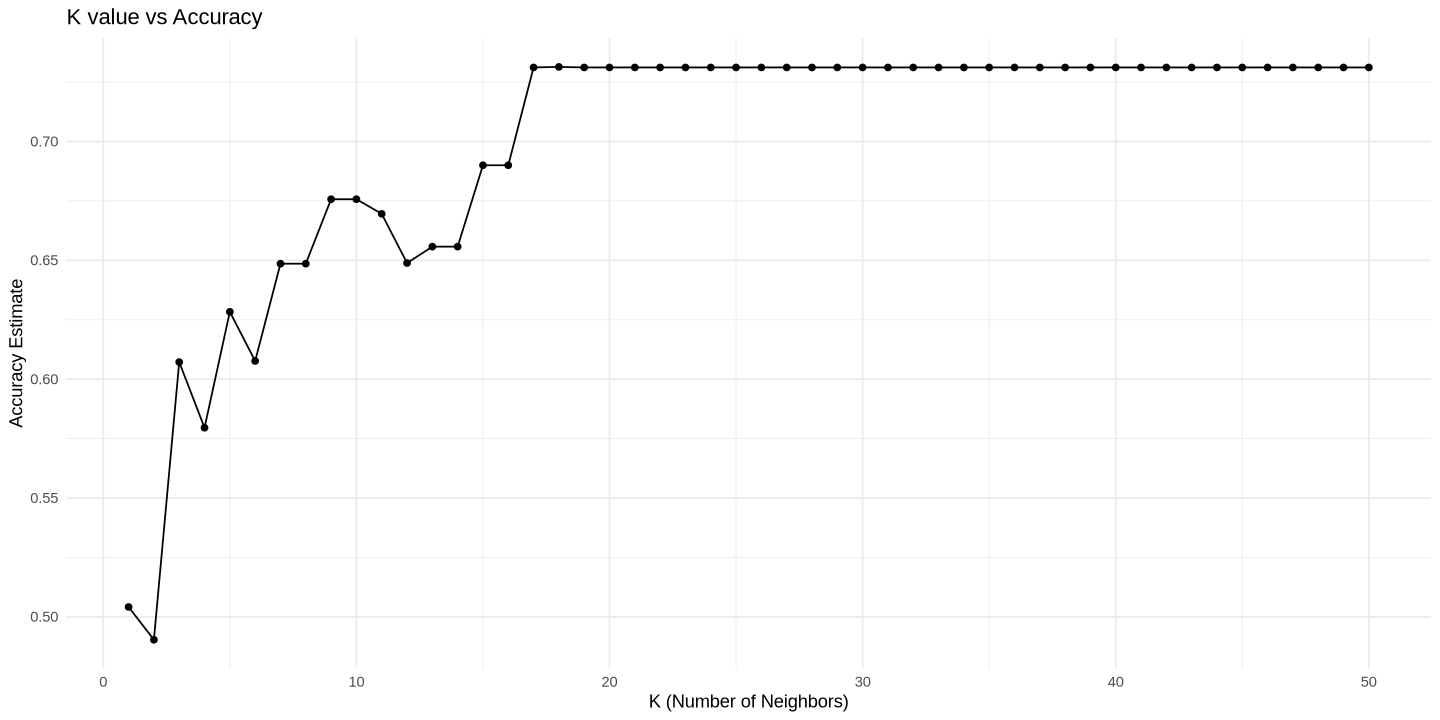

In [9]:
accuracies <- knn_results |>
  collect_metrics() |>
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(
    title = "K value vs Accuracy",
    x = "K (Number of Neighbors)",
    y = "Accuracy Estimate"
  ) +
  theme_minimal()

accuracy_vs_k

Figure ?: K-value vs Accuracy Estimate

This plot shows how the accuracy of our KNN model changes as we try different values of K.
At the beginning, when K is small, the accuracy jumps around a lot. But once K gets close to 30, it starts to level off and stays pretty stable at around 73.5%.
That means using a K value around 30 or a bit higher might give us a more reliable model.

### Choose the best k value
After examining the graph, we selected the k value that had the highest average accuracy.

In [10]:
best_k <- accuracies |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)
best_k

[1] 18

### Train the final model with the best k
Using the best k value we found, we built a new KNN model and trained it on the full training dataset. This time, we did not hold out any part of the training data for validation. Instead, we wanted the model to learn from all available training data before testing it on the separate test set.

In [11]:
final_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

final_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(final_knn_spec)

final_fit <- final_workflow |>
  fit(data = player_train)

### Make predictions and evaluate the final model
Finally, we used the trained model to predict subscription status on the test data. We then calculated several evaluation metrics, including accuracy, precision, and recall.

In [12]:
test_predictions <- predict(final_fit, player_test) |>
  bind_cols(player_test)

# Accuracy
test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

# Precision
test_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "second")

# Recall
test_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "second")

# matrix
confusion <- test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)
confusion


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7291667


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9722222


          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE     13   35

Confusion Matrix of KNN Predictions on Test Set

#### Summary of Findings

Using Age and played_hours, we can roughly predict whether a player will subscribe to the newsletter. On the test set, the model reached about 71.4% accuracy, 72.9% precision, and 97.2% recall. The model is very good at identifying subscribed players (high recall), but it sometimes incorrectly predicts that non-subscribers are subscribed (lower precision).

#### Is This What I Expected?
This result is partly what I expected.
Players who have played more hours might be more engaged with the game, which makes them more likely to subscribe.
However, I thought age would have a bigger effect. Based on the plot, age is more spread out and doesn’t seem to show a clear pattern.

#### Potential Impact
This model could help a company identify players who are likely to subscribe, so they can target them with marketing messages or special promotions.
If we include more features like game level or login frequency, the model might become even more accurate.

#### Future Questions
What other variables could help improve the prediction? Maybe preferred game types or how often players interact with the platform.
Could we build an automated system that recommends newsletter subscriptions in real time?
Are there differences between age groups? For example, do younger and older players subscribe at different rates?